In [854]:

import tools
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import time
%load_ext snakeviz
import os   
import pickle
import pprint
import lit 

def compute_gradJ_and_J(u):
    def f(th,u):
        return -1.0 * np.sum(vt.dealias(u) * st.grad(st.dealias(th)), 0) + kappa * st.lap(st.dealias(th))
    
    def g(phi,u):
        return -1.0 * np.sum(vt.dealias(u) * st.grad(st.dealias(phi)), 0) - kappa * st.lap(st.dealias(phi))

    # Forward integration
    th = np.zeros((M,N,N))
    th[0] = th0
    for i in range(M-1):
        th[i+1] = th[i] + dt*f(th[i],u[i])
        
    # Compute objective
    obj = 0.5*st.hm1norm(th[M-1])**2
    
    # Backward integration
    phi = np.zeros((M,N,N))    
    phi[M-1] = st.invlap(th[M-1]) 
    for i in reversed(range(M-1)):
        phi[i] = phi[i+1] - dt*g(phi[i+1],u[i+1])
    
    
    grad = np.zeros((M,2,N,N))
    for i in range(M):
        grad[i] = st.dealias(phi[i])*vt.dealias(st.grad(th[i]))
        grad[i] = vt.div_free_proj(grad[i])
    
    # compute mu
    integ = 0 
    for i in range(M):
        integ += st.sint(sum(vt.lap(u[i])*vt.invlap(grad[i]),0))*dt
    mu = -1./(gamma**2.*L**2.*T)*integ

    for i in range(M):
        grad[i] = grad[i] - mu* vt.lap(u[i])
    print(mu)
    return grad, obj, mu

def normalize(v):
    return v*(gamma*L)/mean_enstrophy(v)**0.5

def mean_enstrophy(v):
    integ =0
    for i in range(M):
        integ += vt.h1norm(v[i])**2.*dt
    integ = (1./T)*integ
    return integ

def is_incompressible(v):
    cond = True
    for i in range(M):
        cond = cond * vt.is_incompressible(v[i])
    return cond == 1
    
def proj(d,v):
    integ =0
    normsq = 0
    lapv = np.zeros(np.shape(v))
    for i in range(M):
        lapv[i] = vt.lap(v[i])
        integ += st.sint(sum(-lapv[i]*d[i],0))*dt
        normsq += st.sint(sum(lapv[i]*lapv[i],0))*dt
    integ = (1./T)*integ
    return d - integ * (-lapv/normsq)
    
N = 32
M = 10 
L = 1.0
h = L/N
T = 0.1
dt = T/M
kappa = 0.0
gamma = 1.0

st = tools.ScalarTool(N,L)
vt = tools.VectorTool(N,L)

sol_lit = lit.sim(N=N,M=M-1,Pe = np.inf,plot=False,T=T,save_th_every=M,save_u_every=1)
u = np.array(sol_lit.hist_u)
print(u.shape)
th0 = sol_lit.hist_th[0]


print(u.shape)
print(len(sol_lit.hist_u_time))
print(vt.h1norm(u[0]))
print(sol_lit.T)

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz
dt =  0.011111111111111112
(10, 2, 32, 32)
(10, 2, 32, 32)
10
1.0
0.1


In [775]:
print(u.shape)
grad,_,mu = compute_gradJ_and_J(u)

print(grad.shape)


(10, 2, 32, 32)
0.000857136405039
(10, 2, 32, 32)


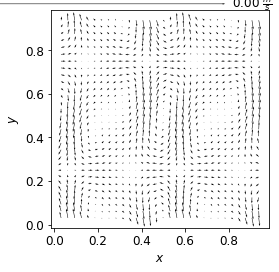

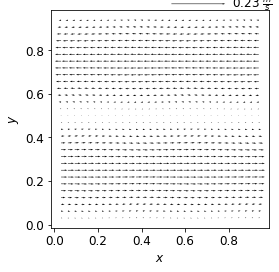

In [562]:
vt.plot(grad[0])
plt.show()
vt.plot(u[0])

In [778]:

eps = 0.000000001
gradJ, J0, mu  = compute_gradJ_and_J(u)
d = np.zeros((M,2,N,N))
for i in range(M):
    d[i] = vt.invlap(gradJ[i])

d = d/(sum((d*d).ravel())*dt*h**2)**0.5

_, J1,_  = compute_gradJ_and_J(normalize(u + eps*d))
_, J2,_  = compute_gradJ_and_J(normalize(u - eps*d))
_, J1,_  = compute_gradJ_and_J(u + eps*d)
_, J2,_  = compute_gradJ_and_J(u - eps*d)
num_gradJ_dot_d = (J1 - J2)/(2.*eps)
grad_J_dot_d = sum((gradJ*d).ravel())*dt*h**2.
print(grad_J_dot_d,num_gradJ_dot_d,J0)
#u = u + eps*d

0.000857136405039
0.000857136405146
0.000857136404932
0.000857136405146
0.000857136404932
-8.94862552883e-06 -6.68345587207e-06 0.00628065831104


In [779]:
integ = 0
eps = 1e-4
for i in range(M):
    #integ+=vt.h1norm(u[i]+eps*d[i])**2.*dt
    integ+=st.sint(sum(vt.lap(u[i])*d[i],0))*dt

print(integ)

8.03140106503e-14


In [760]:
mean_enstrophy(d)

401.34922849717373

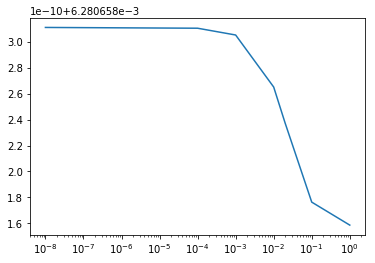

0.00628065831104


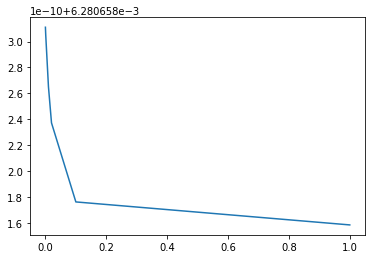

In [746]:
alpha_list = [1.0,0.1,0.02,0.01,0.001,0.0001,0.00000001]
J = np.zeros(len(alpha_list))
for i,alpha in enumerate(alpha_list):
    _, J[i],_  = compute_gradJ_and_J(normalize(u + alpha*d))
plt.semilogx(alpha_list,J)
plt.show()
plt.plot(alpha_list,J)
_, J0,_  = compute_gradJ_and_J(u)
print(J0)

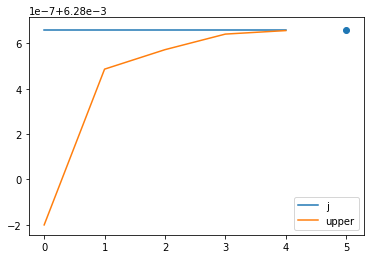

[0.0062806581580035674, 0.0062806581580036732, 0.00628065815800374, 0.0062806581580038831, 0.0062806581580039447]
0.006280658158 True True


In [754]:
def line_search(u, f0, df, d):
    
    alpha_list = [0.5,0.1,0.05,0.01,0.001]
    c=10.0**-3
    func_eval_list = []
    func_upper_list = []
    for alpha in alpha_list:
        _,func_eval,_ =  compute_gradJ_and_J(normalize(u + alpha*d))
        #print(func_eval)
        func_eval_list.append(func_eval)
        func_upper = f0 + c*alpha*sum((np.array(df)*np.array(d)).ravel())*(L/float(N))**2.0*dt
        #print(func_upper)
        func_upper_list.append(func_upper)
        if func_eval < func_upper:
            print('Alpha = ',alpha,'satisfies Wolfe condition 1')
            plt.figure()
            plt.plot(func_eval_list,label = 'j')
            plt.plot(func_upper_list,label = 'upper')
            plt.scatter([len(alpha_list)],[f0])
            plt.legend()
            plt.show()
            print(func_eval_list)
            return alpha
        
    plt.figure()
    plt.plot(func_eval_list,label = 'j')
    plt.plot(func_upper_list,label = 'upper')
    plt.scatter([len(alpha_list)],[f0])
    plt.legend()
    plt.show()
    print(func_eval_list)
    return alpha_list[func_eval_list.index((min(func_eval_list)))]

gradJ, J0,_  = compute_gradJ_and_J(u)
alpha = line_search(u, J0, gradJ, d) 
u = normalize(u + alpha*d)
print(J0, np.isclose(mean_enstrophy(u),gamma**2*L**2),is_incompressible(u))

In [752]:
2.5390145358**0.5

1.5934285474410204

1.5707963267948966

In [644]:
is_incompressible(u)

True

In [727]:
normalize(u + alpha*d)

array([[[[ -7.66225973e-15,   3.19706093e-02,   6.36756397e-02, ...,
           -9.45346447e-02,  -6.36756397e-02,  -3.19706093e-02],
         [  1.60368780e-02,   4.51889549e-02,   7.18468181e-02, ...,
           -8.37633523e-02,  -4.91883074e-02,  -1.55631248e-02],
         [  2.93651204e-02,   5.31351027e-02,   7.26143903e-02, ...,
           -6.59328128e-02,  -3.11238482e-02,   1.11291121e-03],
         ..., 
         [ -3.78475726e-02,  -1.49941454e-02,   1.31413153e-02, ...,
           -7.38997200e-02,  -6.66180044e-02,  -5.49243757e-02],
         [ -2.93651204e-02,  -1.11291121e-03,   3.11238482e-02, ...,
           -8.83493331e-02,  -7.26143903e-02,  -5.31351027e-02],
         [ -1.60368780e-02,   1.55631248e-02,   4.91883074e-02, ...,
           -9.60049954e-02,  -7.18468181e-02,  -4.51889549e-02]],

        [[ -9.18051699e-15,  -1.60866459e-02,  -2.97182327e-02, ...,
            3.88169859e-02,   2.97182327e-02,   1.60866459e-02],
         [ -8.59621216e-02,  -9.91188365e-02,

In [856]:
d= np.random.random((M,2,N,N))
d = proj(d,u)
integ =0
for i in range(M):
    integ += st.sint(sum(-vt.lap(u[i])*d[i],0))*dt
integ = (1./T)*integ
print(integ)

0.229154936564


In [857]:
integ =0
normsq = 0
d= np.random.random((M,2,N,N))
v= np.random.random((M,2,N,N))
d = proj(d,v)

lapv = np.zeros(np.shape(v))
for i in range(M):
    lapv[i] = vt.lap(v[i])
    integ += st.sint(sum(-lapv[i]*d[i],0))*dt
    normsq += st.sint(sum(lapv[i]*lapv[i],0))*dt
integ = (1./T)*integ

print(integ)


-185.009756633
